In [4]:
%matplotlib ipympl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import pickle # to access dataframe faster than csv
import glob, re
import os
import csv
from pathlib import Path
import scipy as sp


In [ ]:
import networkx
import torch_geometric
from torch_geometric.utils.convert import from_networkx

### Get LCLids to ignore due to limited data

In [6]:
file = open('preprocessed_dfs/batch_1_durations.pkl', 'rb')
df_b1 = pickle.load(file)

file = open('preprocessed_dfs/batch_2_durations.pkl', 'rb')
df_b2 = pickle.load(file)

file = open('preprocessed_dfs/batch_3_durations.pkl', 'rb')
df_b3 = pickle.load(file)

file = open('preprocessed_dfs/batch_4_durations.pkl', 'rb')
df_b4 = pickle.load(file)

windows_df_all = pd.concat([df_b1, df_b2, df_b3, df_b4])

windows_df_all.sort_values(by=['Duration'], inplace = True)
windows_ri_all = windows_df_all.reset_index()
windows_ri_all['LCLid'] = windows_ri_all['LCLid'].apply(lambda x: int(re.sub('\D', '', x)))
windows_ri_all.drop(columns = ['index'], inplace = True)
# drop duplicates
print('Number of duplicates: ', windows_ri_all.duplicated(subset=['LCLid']).sum())
print('because of concatenating 4 batches. 1 id common between every 2 batches')
windows_ri_uq = windows_ri_all.drop_duplicates(subset = ['LCLid']).copy()

Number of duplicates:  3
because of concatenating 4 batches. 1 id common between every 2 batches


In [7]:
# get the list of ignored MACid with zero duration.
ignored_ids=windows_ri_all[windows_ri_all['Duration']==pd.Timedelta(0)]['LCLid'] # ids with zero duration
ignored_MACs=[f'MAC{lclid:06d}' for lclid in ignored_ids] # 

### Clean data 

In [8]:
filenames = sorted(glob.glob('uk-smart-meter-data/LCL-June2015v2_*.csv'))
dest_path='uk_smart_meter_cleaned_imputed'

In [9]:
tot=0
tot_dropped=0
stdortou_dict={}
if False: # make this true for first time
    for filepath in filenames:
        filename = filepath.split('/')[-1].split('\\')[-1].split('.')[0] # uk-smart-meter-data\LCL-June2015v2_0.csv >> LCL-June2015v2_0
        data = pd.read_csv(filepath) 
        data['DateTime']=pd.to_datetime(data['DateTime'])
        data['minutes'] = data['DateTime'].dt.minute
        ## Remove readings not at exact 30 minute intervals.
        filtered_data=data[(data['minutes']==0) | (data['minutes']==30)].drop(columns=['minutes'])
        
        ## Remove duplicates
        filtered_data=filtered_data.drop_duplicates(subset=['DateTime', 'LCLid'], keep='last',inplace=False)
        
        ## Remove data outside 2012-2013
        filtered_data=filtered_data[(filtered_data['DateTime'].dt.year >= 2012) & (filtered_data['DateTime'].dt.year <= 2013)]
        
        ## Ignore LCLids with limited data # remove the rows with LCLid duration 0
        filtered_data=filtered_data[~filtered_data['LCLid'].isin(ignored_MACs)]
        
        for _, row in filtered_data.drop_duplicates(subset=['LCLid']).iterrows():
            lclid = row['LCLid']
            stdortou = row['stdorToU']
            if lclid not in stdortou_dict:
                stdortou_dict[lclid] = stdortou
        
        
        filtered_data=filtered_data.drop(columns=['stdorToU'])
        ## Save to CSV
        filtered_data.reset_index(drop=True,inplace=True)
        filtered_data.to_csv(os.path.join(dest_path,f"{filename}_cleaned"),index=False)
    stdortou_df=pd.DataFrame(list(stdortou_dict.items()),columns=['LCLid','stdorToU'])
    stdortou_df.to_csv(os.path.join(dest_path,'stdorTou_mapping.csv'),index=False)

### Aggregate over each hour

In [10]:
def get_filenum(filename):
    match=re.search(r'June2015v2_(\d+)_cleaned',filename)
    return int(match.group(1) if match else float('inf'))

In [11]:
# instead of sorting 0,1,100,101,102,... 167, 2, 3, 4, ... i.e., lexicographically, sort numerically 0,1,2,3,... 167
filenames = sorted(glob.glob('uk_smart_meter_cleaned_imputed/LCL-June2015v2_*'))
filenames=sorted(filenames,key=get_filenum)

In [12]:
def process_chunk(chunk_data, prior_data=None, final_chunk=False):
    chunk_data['DateTime']=pd.to_datetime(chunk_data['DateTime'])
    
    if prior_data is not None:
        chunk_data=pd.concat([prior_data,chunk_data])
        
    if ~final_chunk:
        last_id=chunk_data['LCLid'].unique()[-1]
        prior_data=chunk_data[chunk_data['LCLid']==last_id]
        chunk_data=chunk_data[chunk_data['LCLid']!=last_id]
        
    pivoted_chunk = chunk_data.pivot(index='DateTime', columns='LCLid', values='KWH/hh (per half hour) ')
    aggregated_chunk = pivoted_chunk.resample('1h').sum(min_count=1)
    return prior_data,aggregated_chunk
    

In [13]:
if False: # true to create chunks in your local machine
    dest_path="uk_smart_meter_aggregated"
    chunk_size = 21
    data = pd.DataFrame()
    data_dict={}
    chunk_num=1
    for chunk_start in range(0,len(filenames),chunk_size):
        chunk_data=pd.DataFrame()
        prior_data=None
        final_chunk=False
        for filename in filenames[chunk_start:chunk_start+chunk_size]:
            #print(filename)
            chunk_data=pd.concat([chunk_data,pd.read_csv(filename)])
        if len(filenames)<=chunk_start+chunk_size:
            final_chunk=True
        prior_data,agg_chunk=process_chunk(chunk_data,prior_data,final_chunk)
        agg_chunk.to_csv(os.path.join(dest_path,f'aggregated_chunk_{chunk_num}.csv'))
        print(f"Chunk {chunk_num} saved.")
        chunk_num+=1


### Define batch times

In [5]:
def blocked_cross_validation(df,train_months=3,test_months=1,overlap_months=0):
    """
    return: list of tuples containing (train_start_date, train_end_date, test_start_date, test_end_date) for year 2012-2013
    """
    blocks=[]
    start_date=df['DateTime'].iloc[0]
    end_date=df['DateTime'].iloc[-1]
    current_train_start=start_date
    while current_train_start+pd.DateOffset(months=train_months+test_months)<=end_date:
        train_end=current_train_start+pd.DateOffset(months=train_months)-pd.Timedelta(hours=1)
        test_start=train_end+pd.Timedelta(hours=1)
        test_end = test_start + pd.DateOffset(months=test_months) - pd.Timedelta(hours=1)
        blocks.append((current_train_start, train_end, test_start, test_end))
        current_train_start = current_train_start + pd.DateOffset(months=train_months + test_months - overlap_months)
    return blocks

In [6]:
df = pd.DataFrame({
    'DateTime': pd.date_range(start='2012-01-01 00:00:00', end='2013-12-31 23:00:00', freq='1h')
})
train_months=3
test_months=1
overlap_months=0
cv_blocks=blocked_cross_validation(df,train_months,test_months,overlap_months) 

### Get splits as timestamps

In [23]:
def get_windows(start,end,in_window,out_window):
    timestamps=[]
    in_stamps=[]
    out_stamps=[]
    current=start
    while current+pd.Timedelta(hours=in_window+out_window)<=end+pd.Timedelta(hours=1):
        in_stamps.append(pd.date_range(start=current,periods=in_window,freq='h'))
        out_stamps.append(pd.date_range(start=current+pd.Timedelta(hours=in_window),periods=out_window,freq='h'))
        current+=pd.Timedelta(hours=1)
    return in_stamps,out_stamps

In [66]:
def get_train_test_times(cv_block,in_window,out_window=6,overlap=False):
    train_start,train_end,test_start,test_end=cv_block
    train_x,train_y=get_windows(start=train_start,end=train_end,in_window=in_window,out_window=out_window)
    test_x,test_y=get_windows(start=test_start,end=test_end,in_window=in_window,out_window=out_window)
    # Overlap takes cases where in_window can contain data from training data but out_window is entirely in testing data
    if overlap:
        overlap_start = train_end - pd.Timedelta(hours=in_window - 1)
        overlap_end = test_start + pd.Timedelta(hours=out_window - 1)
        overlap_in, overlap_out = get_windows(overlap_start, overlap_end, in_window, out_window)
        test_x = overlap_in + test_x
        test_y = overlap_out + test_y
    return train_x,train_y,test_x,test_y
    

In [67]:
train_x=[]
train_y=[]
test_x=[]
test_y=[]
for block in cv_blocks:
    trn_x,trn_y,tst_x,tst_y=get_train_test_times(block,in_window=6,out_window=6,overlap=True)
    train_x.append(trn_x)
    train_y.append(trn_y)
    test_x.append(tst_x)
    test_y.append(tst_y)

In [68]:
train_x[0][0],train_y[0][0]

(DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
                '2012-01-01 02:00:00', '2012-01-01 03:00:00',
                '2012-01-01 04:00:00', '2012-01-01 05:00:00'],
               dtype='datetime64[ns]', freq='h'),
 DatetimeIndex(['2012-01-01 06:00:00', '2012-01-01 07:00:00',
                '2012-01-01 08:00:00', '2012-01-01 09:00:00',
                '2012-01-01 10:00:00', '2012-01-01 11:00:00'],
               dtype='datetime64[ns]', freq='h'))

In [69]:
train_x[0][-1],train_y[0][-1]

(DatetimeIndex(['2012-03-31 12:00:00', '2012-03-31 13:00:00',
                '2012-03-31 14:00:00', '2012-03-31 15:00:00',
                '2012-03-31 16:00:00', '2012-03-31 17:00:00'],
               dtype='datetime64[ns]', freq='h'),
 DatetimeIndex(['2012-03-31 18:00:00', '2012-03-31 19:00:00',
                '2012-03-31 20:00:00', '2012-03-31 21:00:00',
                '2012-03-31 22:00:00', '2012-03-31 23:00:00'],
               dtype='datetime64[ns]', freq='h'))

In [70]:
test_x[0][0],test_y[0][0]

(DatetimeIndex(['2012-03-31 18:00:00', '2012-03-31 19:00:00',
                '2012-03-31 20:00:00', '2012-03-31 21:00:00',
                '2012-03-31 22:00:00', '2012-03-31 23:00:00'],
               dtype='datetime64[ns]', freq='h'),
 DatetimeIndex(['2012-04-01 00:00:00', '2012-04-01 01:00:00',
                '2012-04-01 02:00:00', '2012-04-01 03:00:00',
                '2012-04-01 04:00:00', '2012-04-01 05:00:00'],
               dtype='datetime64[ns]', freq='h'))

### Concatenate the chunk data into a singe dataframe

In [16]:
agg_filepaths = sorted(glob.glob('uk_smart_meter_aggregated/aggregated_chunk_*.csv'))

if False: # Concatenate all chunks into one cookie
    df_agg = pd.DataFrame()
    for agg_filepath in agg_filepaths:
        df_agg = pd.concat([df_agg, pd.read_csv(agg_filepath, index_col = 'DateTime')], axis = 0) # concatenate with respect to DateTime column
    df_agg = df_agg.apply(pd.to_numeric, downcast='float')
    df_agg.info()
    # pickle the file to save time
    df_agg.to_pickle('uk_smart_meter_aggregated/df_agg.pkl')
else:
    file = open('uk_smart_meter_aggregated/df_agg.pkl','rb')
    df_agg = pickle.load(file)



### What are the LCLids in the aggregated data?

In [17]:
# rename df_agg column names; ignore 'MAC0'
if True:
    numeric_columns = [int(re.search(r'\d+', item).group()) for item in df_agg.columns.values]
    list_lclids_agg = np.array(numeric_columns)

In [72]:
# window data for aggregated LCLids; The ids only for the year 2012-2013 
windows_ri_agg = windows_ri_uq[windows_ri_uq['LCLid'].isin(list_lclids_agg)].copy()
if windows_ri_agg.shape[0] == list_lclids_agg.shape[0]:
    print('Aggregated LCLids extracted from the windows data.')

Aggregated LCLids extracted from the windows data.


### Generate similarity matrix for this LCLids using k-nearest neigbour and display the graph.

In [73]:
# given dataframe
windows_ri_agg.sort_values(by='LCLid', inplace = True)
windows_ri_agg.reset_index(inplace = True)
windows_ri_agg.drop(columns = ['index'], inplace = True)
windows_ri_agg

,LCLid,Enabled At,Disabled At,Duration
0,2,2012-10-12 00:30:00,2014-02-28,503 days 23:30:00
1,3,2012-02-20 13:00:00,2014-02-28,738 days 11:00:00
2,4,2012-05-08 13:00:00,2014-02-28,660 days 11:00:00
3,5,2012-06-01 10:30:00,2014-02-28,636 days 13:30:00
4,6,2012-01-30 11:30:00,2014-02-28,759 days 12:30:00
...,...,...,...,...
5553,5561,2012-04-24 12:00:00,2014-02-28,674 days 12:00:00
5554,5562,2012-05-07 00:30:00,2014-02-28,661 days 23:30:00
5555,5564,2012-07-17 10:00:00,2014-02-28,590 days 14:00:00
5556,5566,2012-10-03 00:30:00,2014-02-28,512 days 23:30:00


In [74]:
num_nodes_range = range(len(windows_ri_agg.index))

In [75]:
# Sort rows by start date
windows_ri_agg.sort_values(by='Enabled At', inplace=True)

# Get an ordered list of dates 'Enabled At'
enable_unique_dates = windows_ri_agg['Enabled At'].unique()

# Get a list of lists of LCLids that have the same start date
nbor_lclids = [windows_ri_agg[windows_ri_agg['Enabled At'] == date].index.tolist() for date in enable_unique_dates]
print('Number of unique start dates: ', len(enable_unique_dates))
assert len(windows_ri_agg) == sum([len(l) for l in nbor_lclids])

Number of unique start dates:  2156


In [76]:
max(l for l in nbor_lclids)

[5557]

In [77]:
def create_adjacency_matrix(lclids, k):
    number_of_nodes = sum([len(l) for l in lclids])
    adjacency_matrix = np.zeros((number_of_nodes, number_of_nodes))
    # Create the graph by iterating over the list of lists of LCLids
    # and connecting all nodes in the list with each other
    # and with the k-nearest lists
    for i in range(len(lclids)): # range 2156
        for j in range(len(lclids)): # range 2156 
            if i == j: 
                for lclid in lclids[i]:
                    for lclid2 in lclids[j]:
                        adjacency_matrix[lclid, lclid2] = 1
            elif abs(i-j) <= k:
                for lclid in lclids[i]:
                    for lclid2 in lclids[j]:
                        adjacency_matrix[lclid, lclid2] = 1
    return sp.sparse.bsr_array(adjacency_matrix)

In [78]:
len(nbor_lclids)

2156

In [79]:
adjacency_matrix.shape

(5558, 5558)

Number of nodes:  5558
Graph connected for k=200: True
sparsity:  0.7889075406317442


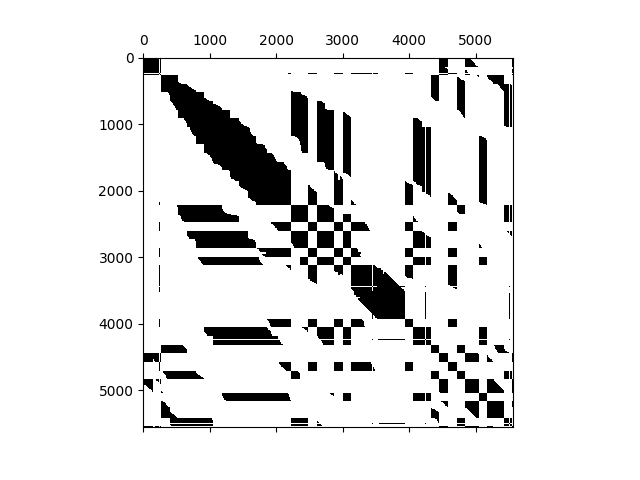

In [80]:
# Create the empty adjacency matrix of the graph
number_of_nodes = len(windows_ri_agg.index)

print('Number of nodes: ', number_of_nodes)


adjacency_matrix = np.zeros((number_of_nodes, number_of_nodes))
# K-nearest neighbours
k = 200

adjacency_matrix = create_adjacency_matrix(nbor_lclids, k)
# Compute the sparsity of the adjacency matrix
sparsity = 1 - sp.sparse.bsr_matrix.count_nonzero(adjacency_matrix) / np.prod(adjacency_matrix.shape)
G = networkx.from_scipy_sparse_array(adjacency_matrix)
print(f'Graph connected for k={k}: {networkx.is_connected(G)}')
print('sparsity: ', sparsity)

plt.spy(sp.sparse.bsr_matrix.toarray(adjacency_matrix))
plt.show()

### Temporal Learning next!

In [82]:
pyg_graph = from_networkx(G)
pyg_graph

Data(edge_index=[2, 6768116], weight=[6768116], num_nodes=5558)